# O Problema


Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

Origem dos dados: Arquivo 'insurance.csv' obtido através do github do curso(https://github.com/FIAP/CURSO_IA_ML)

## 1. Importando e Analisando os dados

In [40]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='darkgrid')
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

df = pd.read_csv("/content/drive/MyDrive/colab-data/seguro-saude.csv")
df.shape


(1341, 7)

In [3]:
df.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,56,feminino,29.774374,2,sim,sudoeste,31109.889763
1,46,masculino,25.857395,1,não,nordeste,26650.702647
2,32,masculino,23.014840,0,não,sudoeste,21459.037990
3,19,feminino,27.900000,0,sim,sudoeste,16884.924000
4,18,masculino,33.770000,1,não,sudeste,1725.552300


In [4]:
df.describe()

,idade,imc,filhos,encargos
count,1341.000000,1341.000000,1341.000000,1341.000000
mean,39.219239,30.653446,1.094705,13299.809561
std,14.044321,6.096393,1.204770,12113.807202
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.220000,0.000000,4746.344000
50%,39.000000,30.360000,1.000000,9391.346000
75%,51.000000,34.675000,2.000000,16796.411940
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1341 non-null   int64  
 1   gênero    1341 non-null   object 
 2   imc       1341 non-null   float64
 3   filhos    1341 non-null   int64  
 4   fumante   1341 non-null   object 
 5   região    1341 non-null   object 
 6   encargos  1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


Podemos observar que não há dados nulos e que as colunas que possuem valores do tipo texto são gênero, fumante e região.

In [6]:
df.isnull().sum()

idade       0
gênero      0
imc         0
filhos      0
fumante     0
região      0
encargos    0
dtype: int64

## 2. Representação gráfica dos dados

### Região

In [7]:
regioes = set(df["região"])
print(regioes)

{'sudoeste', 'sudeste', 'nordeste', 'noroeste'}


Text(0, 0.5, 'Quantidade')

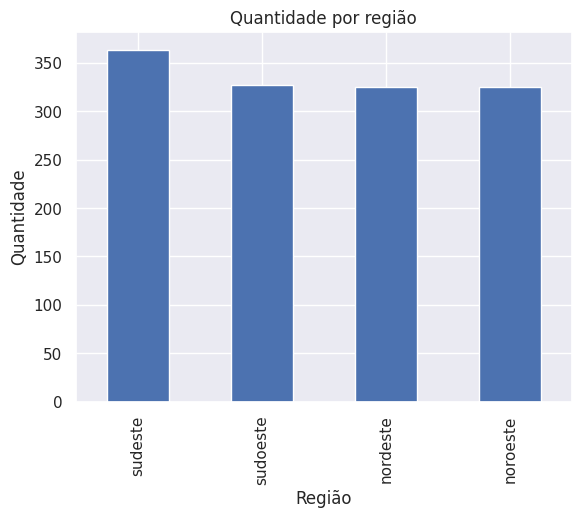

In [8]:
qtd_regiao = df["região"].value_counts()
qtd_regiao.plot(kind='bar')
plt.title('Quantidade por região')
plt.xlabel('Região')
plt.ylabel('Quantidade')

In [9]:
df["região"].value_counts()

região
sudeste     364
sudoeste    327
nordeste    325
noroeste    325
Name: count, dtype: int64

Acima podemos analisar que a coluna região possui 4 categorias e que, apesar da região sudeste possuir uma quantidade ligeiramente maior de pessoas, não cosideraremos isso como um desequilíbrio.

### Gênero

Text(0, 0.5, 'Quantidade')

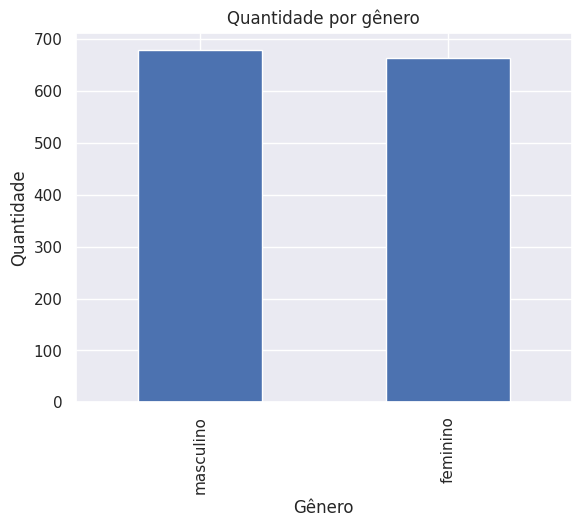

In [10]:
qtd_genero = df["gênero"].value_counts()
qtd_genero.plot(kind='bar')
plt.title('Quantidade por gênero')
plt.xlabel('Gênero')
plt.ylabel('Quantidade')

Acima precebemos que os valores estão be distribuídos na coluna gênero e que ela pode ser facilmente convertida para valores binário ao invés de texto.

### Fumante

Text(0, 0.5, 'Quantidade')

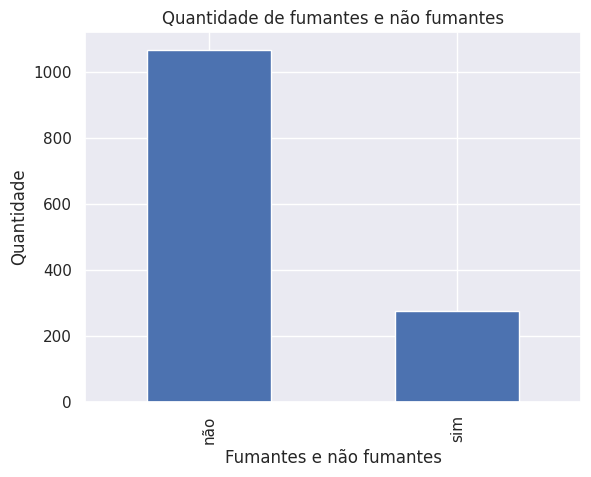

In [11]:
qtd_fumante = df["fumante"].value_counts()
qtd_fumante.plot(kind='bar')
plt.title('Quantidade de fumantes e não fumantes')
plt.xlabel('Fumantes e não fumantes')
plt.ylabel('Quantidade')

A coluna fumante também pode ser convertida em binário, no entanto observa-se que os valores não estão bem distribuídos pois existem muito mais não fumantes do que fumantes.

### Analisando os dados numéricos

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

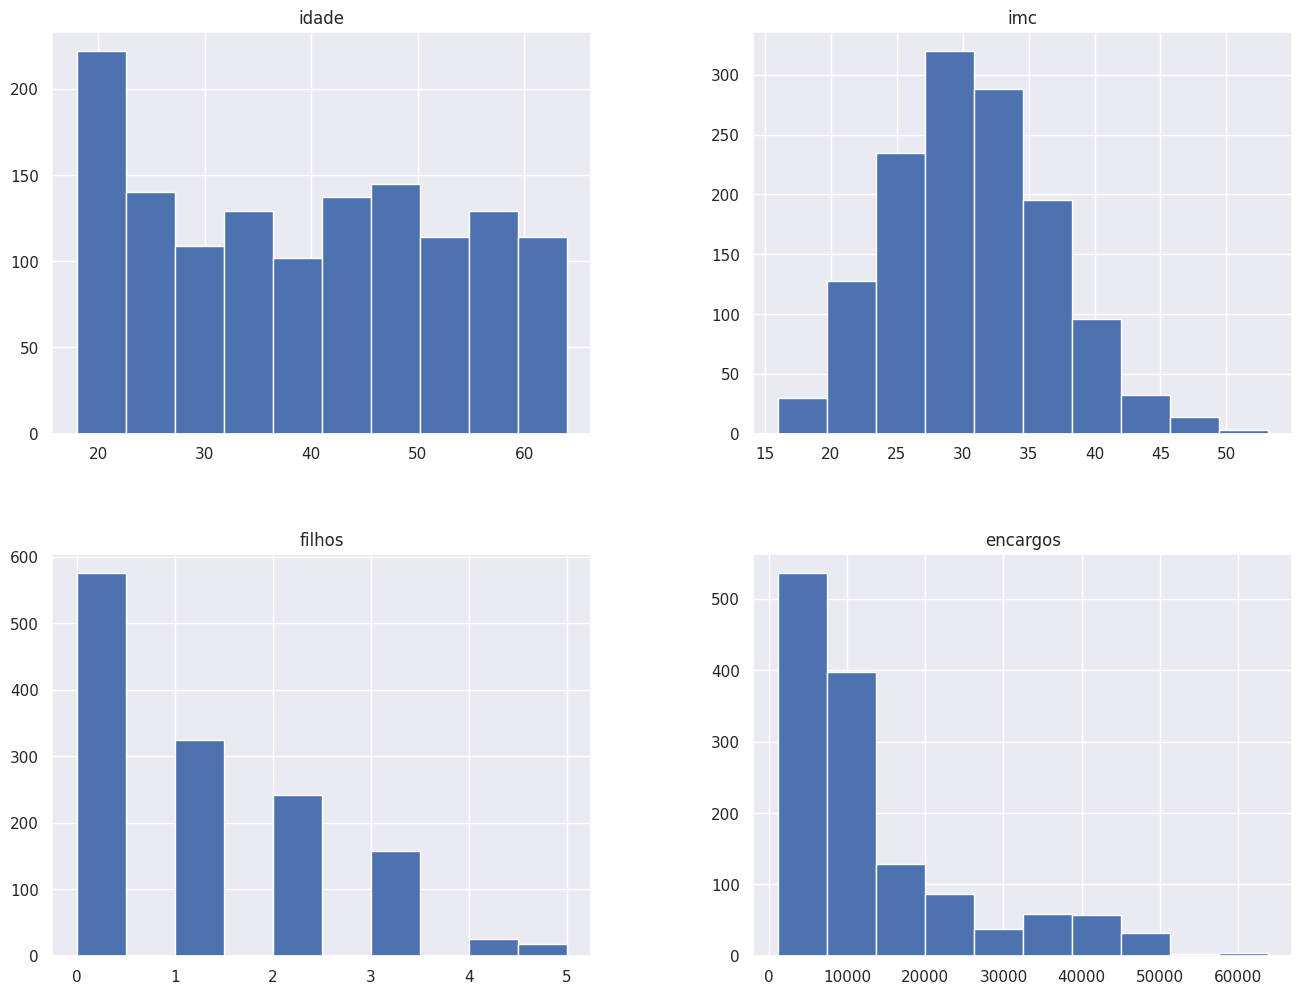

In [12]:
df.hist(figsize=(16, 12))

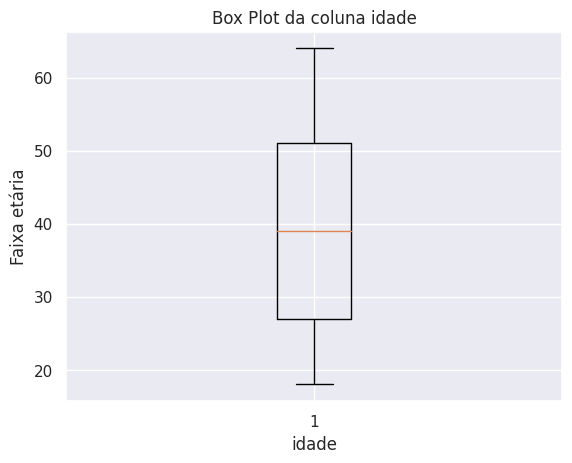

In [13]:
plt.boxplot(df['idade'])
plt.xlabel('idade')
plt.ylabel('Faixa etária')
plt.title(f'Box Plot da coluna idade')
plt.show()

In [14]:
print(df['idade'].min())
print(df['idade'].max())

18
64


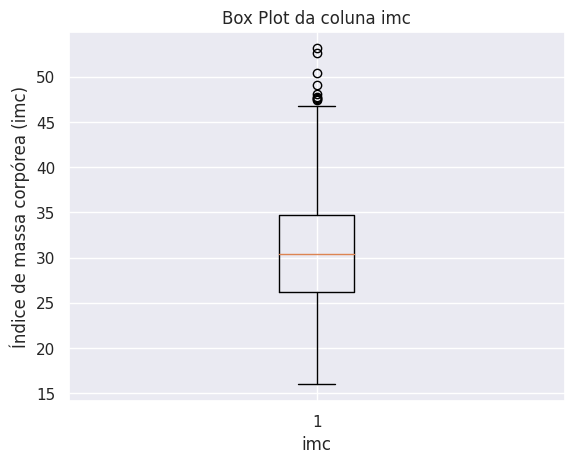

In [15]:
plt.boxplot(df['imc'])
plt.xlabel('imc')
plt.ylabel('Índice de massa corpórea (imc)')
plt.title(f'Box Plot da coluna imc')
plt.show()

In [16]:
print(df['imc'].min())
print(df['imc'].max())

15.96
53.13


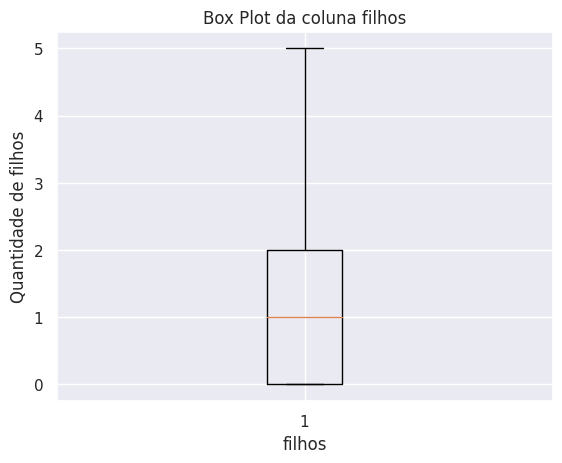

In [17]:
plt.boxplot(df['filhos'])
plt.xlabel('filhos')
plt.ylabel('Quantidade de filhos')
plt.title(f'Box Plot da coluna filhos')
plt.show()

In [18]:
print(df['filhos'].min())
print(df['filhos'].max())

0
5


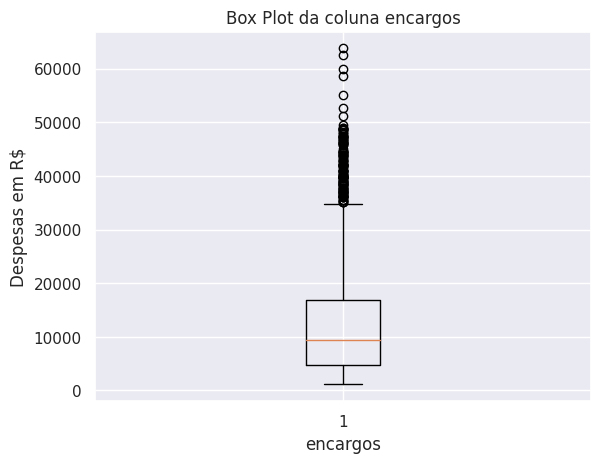

In [19]:
plt.boxplot(df['encargos'])
plt.xlabel('encargos')
plt.ylabel('Despesas em R$')
plt.title(f'Box Plot da coluna encargos')
plt.show()

In [20]:
print(df['encargos'].min())
print(df['encargos'].max())

1121.8739
63770.42801


Outliers encontrados na colunas encargos e imc

## Análise da correlação dos dados

### Região X Encargos totais

In [21]:
# Agrupando os dados para obter o total de encargos e a quantidade de pessoas por região
encargos_por_regiao = df.groupby('região')['encargos'].sum().reset_index()
quantidade_por_regiao = df['região'].value_counts().reset_index()
quantidade_por_regiao.columns = ['região', 'quantidade']

# Mesclando os dois DataFrames
merged_df = pd.merge(encargos_por_regiao, quantidade_por_regiao, on='região')

# Criando o gráfico de barras
fig = px.bar(merged_df, x='região', y=['encargos'],
             title='Quantidade de Pessoas e Encargos Totais por Região',
             text='quantidade',
             labels={'value': 'Encargos', 'variable': 'Métrica', 'região': 'Região', 'quantidade': 'Qtd'})

# Atualizando as barras para mostrar a quantidade e encargos no topo
fig.update_traces(textposition='outside')

# Exibindo o gráfico
fig.show()

Acima podemos observar que o valor total dos encargos por região faz sentido, pois já vimos que a região sudeste possui mais gente do que as demais, a região nordeste apesar de possuir a mesma quantidade de pessoas que as demais, possui um valor total de encargos ligeiramente mais alto, fato este que julgaremos normal pois há outros fatores que podem elevar o custo final do seguro saúde.

### Total de Encargos por Região e Fumante/Não Fumante

In [22]:
grouped_df = df.groupby(['região', 'fumante']).agg({'encargos': 'sum'}).reset_index()
grouped_df['contagem'] = df.groupby(['região', 'fumante']).size().values

fig = px.bar(grouped_df, x="região", y="encargos",
             color='fumante', barmode='group',text='contagem', title='Total de Encargos por Região e Fumante/Não Fumante',
             labels={'encargos': 'Encargos', 'fumante': 'Fumante', 'região': 'Região', 'contagem': 'Qtd'})

fig.update_traces(textposition='outside')
fig.show()

Aqui fica claro que o fato de ser fumante influencia muito no valor final do seguro saúde, observe que na região sudeste temos 273 não fumantes totalizando pouco mais que 2 milhões e apenas 91 fumantes que totaliza mais de 3 milhões.

### Total de Encargos por Região, Gênero e Fumante/Não Fumante

Ao analizar o total de encargos por gênero decidimos separar por fumantes e não fumantes, uma vez que vimos que essa característica afeta e muito o preço final.

In [23]:
grouped_df = df.groupby(['região', 'gênero', 'fumante']).agg({'encargos': 'sum'}).reset_index()
grouped_df['contagem'] = df.groupby(['região', 'gênero', 'fumante']).size().values

fig = px.bar(grouped_df, x='região', y='encargos', color='gênero', barmode='group',
             facet_col='fumante', text='contagem', title='Total de Encargos por Região, Gênero e Fumante/Não Fumante',
             labels={'encargos': 'Encargos', 'fumante': 'Fumante', 'região': 'Região', 'contagem': 'Qtd', 'gênero': 'Gênero'})

fig.update_traces(textposition='outside')
fig.show()

Podemos observar que apenas o gênero em si não afeta o preço e que as diferenças apresentadas são mero fruto do quantitativo.

### Total de Encargos por Região, Fumante e Quantidade de Filhos

O gráfico box plot por quantidade de filhos já nos revelou que, em relação à quantidade de filhos, os dados estão concentrado na região de 0 à 2 filhos, portanto um gráfico de quantidade de filhos por região não faz muito sentido, uma vez que o quantitativo seria o maior responsável pela discrepância dos valores.

Vamos agora visualizar 2 gráficos de barras empilhadas que se correlacionam e estão divididos por fumantes e não fumantes

In [24]:
encargos_agrupados = df.groupby(['região', 'fumante', 'filhos'])['encargos'].sum().reset_index()
quantidade_agrupada = df.groupby(['região', 'fumante', 'filhos']).size().reset_index(name='quantidade')

fig_encargos = px.bar(encargos_agrupados, x='região', y='encargos', color='filhos', facet_col='fumante',
             title='Total de Encargos por Região, Fumante e Quantidade de Filhos',
             labels={'encargos': 'Encargos', 'região': 'Região', 'filhos': 'Filhos', 'fumante': 'Fumante'})
fig_quantidade = px.bar(quantidade_agrupada, x='região', y='quantidade', color='filhos', facet_col='fumante',
             title='Quantidade de Pessoas por Região, Fumante e Quantidade de Filhos',
             labels={'quantidade': 'Qtd', 'região': 'Região', 'filhos': 'Filhos', 'fumante': 'Fumante'})


fig_encargos.update_traces(texttemplate='%{y}', textposition='outside')
fig_quantidade.update_traces(texttemplate='%{y}', textposition='outside')

fig_encargos.show()
fig_quantidade.show()

Os gráficos acima nos mostram que a quantidade filhos em relação à região não parecem influenciar tanto os preços quando separamos por fumantes/não fumantes, obseve os gráficos de não fumantes e preceba as pessoas com 0 e 1 filhos nas regiões sudeste e sudoeste, elas possuem um quantitativo parecido e o valor total dos encargos estão bem próximos também.
Agora observe o gráfico de não fumantes e veja as pessoas com 2 filhos nas regiões sudeste e sudoeste, ambos estados possuem 18 e o valoes estão bem próximos, o que parece ser uma variância normal de acordo com a região e outros fatores como IMC e idade.

Fazer as mesmas análises acima utilizando o IMC ou idade não faz muito sentido pois o agrupamento não funcionaria muito bem uma vez que os valores dessas colunas são muito distintos.

### Transformando os dados de texto em numéricos

Para visualizarmos a matriz de correlação, precisanmos tranformar as colunas de texto em valores numéricos, pra isso vamos utilizar o LabelEncoder, que basicamente, irá criar um label numérico relacionado com cada valor de texto em cada coluna.

In [25]:
df_num = df.copy(deep=True)
label_encoder = LabelEncoder()
df_num['gênero'] = label_encoder.fit_transform(df['gênero'])
df_num['fumante'] = label_encoder.fit_transform(df['fumante'])
df_num['região'] = label_encoder.fit_transform(df['região'])
df_num.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,56,0,29.774374,2,1,3,31109.889763
1,46,1,25.857395,1,0,0,26650.702647
2,32,1,23.014840,0,0,3,21459.037990
3,19,0,27.900000,0,1,3,16884.924000
4,18,1,33.770000,1,0,2,1725.552300


In [26]:
# Criando o gráfico de dispersão
fig = px.scatter(df_num, x='idade', y='encargos', color='fumante', symbol='gênero', size='imc',
                 facet_col='região', title='Dispersão dos Encargos por Idade, Fumante, Gênero e Região',
                 labels={'idade': 'Idade', 'encargos': 'Encargos', 'fumante': 'Fumante', 'gênero': 'Gênero', 'imc': 'IMC', 'região': 'Região'})

# Exibindo o gráfico
fig.show()

No gráfico de dispersão acima podemos ver que a idade e ser fumante ou não são fortes indicadores de aumento dos encargos totais, no entanto, não podemos deixar de observar que o IMC também aumenta significativamente, observe os gráficos da região 0 e 2, tem um losango localizado bem acima da linka de 10k e ligeiramente atrás dos 40 anos de idade.
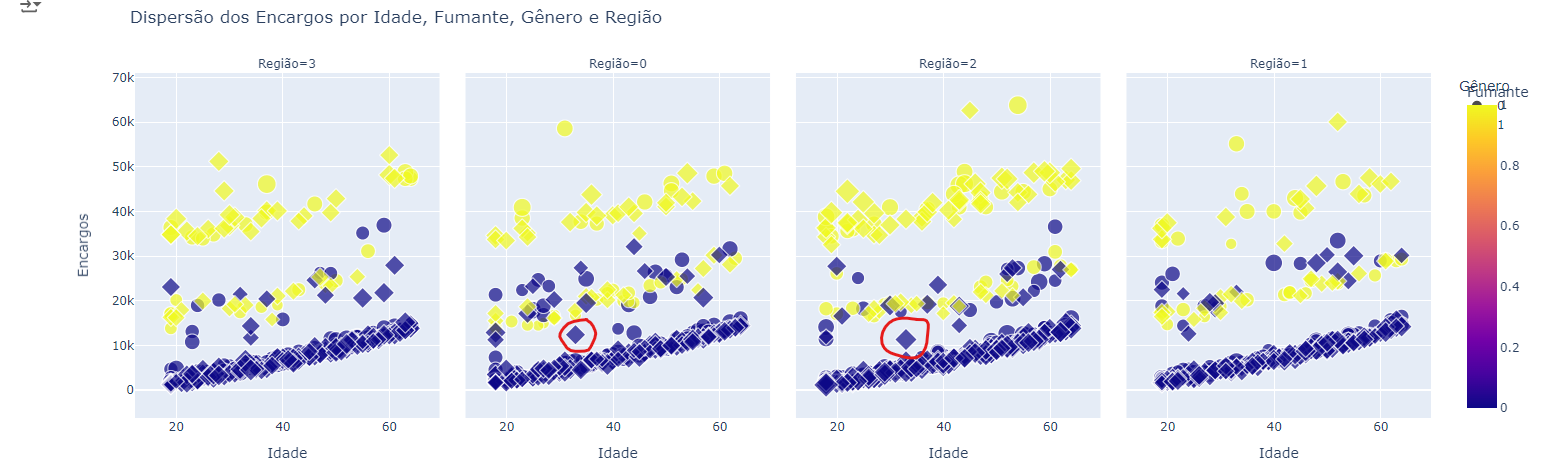

Perceba que os dois casos citados acima, são de idade mediana, 33 anos e não fumantes, mas o IMC alto os distinguiu dos demais de suas características posicionando-os em uma faixa de preço acima dos 10K.

Agora vamos utilizar o mesmo gráfico acima mas desta vez separaremos por quantidade de filhos ao invés de região.

In [27]:
# Criando o gráfico de dispersão
fig = px.scatter(df_num, x='idade', y='encargos', color='fumante', symbol='gênero', size='imc',
                 facet_col='filhos', title='Dispersão dos Encargos por Idade, Fumante, Gênero e Quantidade de filhos',
                 labels={'idade': 'Idade', 'encargos': 'Encargos', 'fumante': 'Fumante', 'gênero': 'Gênero', 'imc': 'IMC', 'filhos': 'Filhos'})

# Exibindo o gráfico
fig.show()

Neste gráfico fica claro que a quantidade de filhos influencia no aumento dos preços também. Observe a imagem abaixo, escolhemos dois homens com caracteríticas muito semelhantes, o home com 0 filhos possui um ano a menos e um IMC ligeiramente maior do que o homem que tem 4 filhos e 37 anos, mesmo assim os encargos deste último é um pouco mais alto, indicando portanto, que quanto mais filhos mais caro será o valor final.
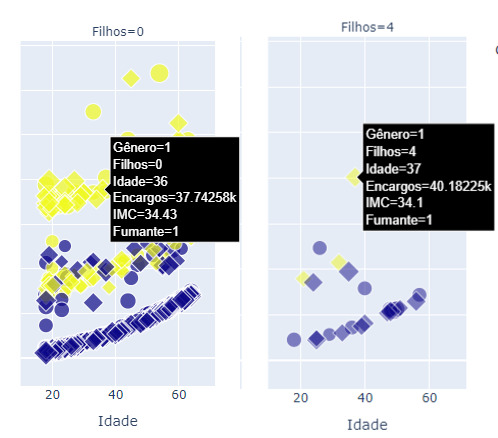

### Matriz de correlação

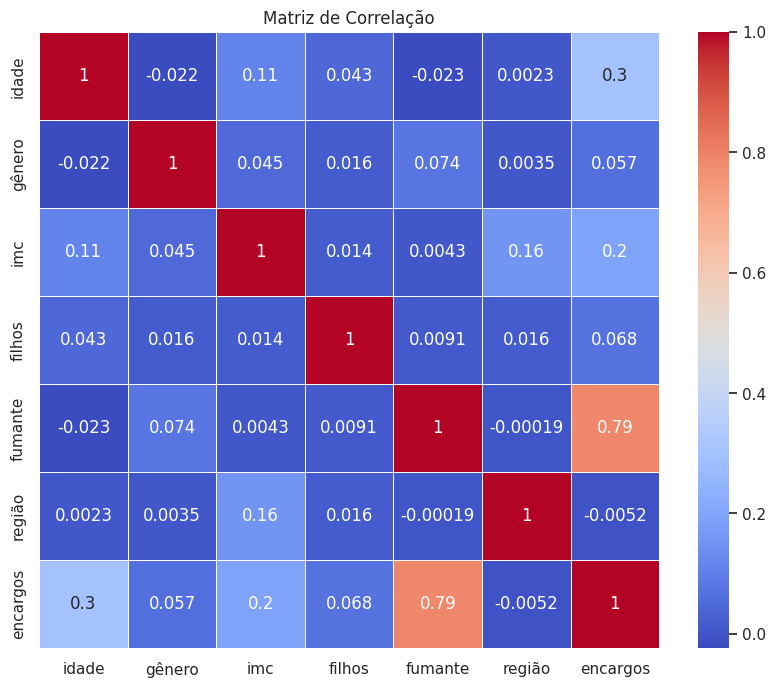

In [28]:
corr_matrix = df_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

A matriz de correlação atesta o que analisamos anteriormente, perceba a relação da colunas com a coluna encargos.
A coluna fumante lidera o ranking, seguida de idade e IMC, filhos e região por último.
Observe que também temos outras correlações importantes como IMC com região e IMC com Idade.

## Pré-processamento dos dados

Para o pré-processamento dos dados utilizaremos o LabelEnconding para as colunas que podem ser representadas de forma binária como gênero e fumante. Para a coluna região utilizaremos One-Hot Encoding com ColumnTransformer.

### Label Encoding

In [29]:
df_modelo = df.copy(deep=True)
df_modelo['gênero'] = label_encoder.fit_transform(df['gênero'])
df_modelo['fumante'] = label_encoder.fit_transform(df['fumante'])
df_modelo.head()


,idade,gênero,imc,filhos,fumante,região,encargos
0,56,0,29.774374,2,1,sudoeste,31109.889763
1,46,1,25.857395,1,0,nordeste,26650.702647
2,32,1,23.014840,0,0,sudoeste,21459.037990
3,19,0,27.900000,0,1,sudoeste,16884.924000
4,18,1,33.770000,1,0,sudeste,1725.552300


Agora temos a representação dos gêneros e fumante/não fumante da seguinte forma:


*   Feminino = 0
*   Masculino = 1


*   Não fumante = 0
*   Fumante = 1

### One-hot encoding e ColumnTransformer

In [30]:
column_transformer = ColumnTransformer(
    transformers=[
        ('região', OneHotEncoder(sparse=False), ['região'])
    ],
    remainder='passthrough'  # Manter as outras colunas inalteradas
)
df_transformado = column_transformer.fit_transform(df_modelo)

# Obter os nomes das novas colunas após One-Hot Encoding
colunas_regiao = column_transformer.named_transformers_['região'].get_feature_names_out(['região'])
# Remover os prefixos do nome das colunas
colunas_regiao = [col.split('_')[-1] for col in colunas_regiao]


# Criar um DataFrame com as colunas transformadas
df_transformado = pd.DataFrame(df_transformado, columns=colunas_regiao + list(df_modelo.columns.drop('região')))

# Apenas para reposicionar as colunas das regiões como as últimas do dataframe
colunas_reorganizadas = list(df.columns.drop('região')) + colunas_regiao
df_transformado =  df_transformado[colunas_reorganizadas]


df_transformado.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,idade,gênero,imc,filhos,fumante,encargos,nordeste,noroeste,sudeste,sudoeste
0,56.0,0.0,29.774374,2.0,1.0,31109.889763,0.0,0.0,0.0,1.0
1,46.0,1.0,25.857395,1.0,0.0,26650.702647,1.0,0.0,0.0,0.0
2,32.0,1.0,23.014840,0.0,0.0,21459.037990,0.0,0.0,0.0,1.0
3,19.0,0.0,27.900000,0.0,1.0,16884.924000,0.0,0.0,0.0,1.0
4,18.0,1.0,33.770000,1.0,0.0,1725.552300,0.0,0.0,1.0,0.0


## Normalização dos dados

Para a normalização dos dados, antes escolhermos entre MinMaxScaler e StandardScaler vamos primeiro checar a normalidade para cada coluna e verificar se cada uma delas segue uma curva gaussiana usando o teste de Shapiro-Wilk.

### Checagem de normalidade

In [31]:
def checar_normalidade(data, column, alpha=0.05):
    stat, p = shapiro(data[column])
    result = 'Normal' if p > alpha else 'Não Normal'
    return {
        'Coluna': column,
        'Estatística': round(stat, 4),
        'p-Valor': round(p, 4),
        'Resultado': result
    }

# Checar a normalidade para cada coluna e armazenar os resultados
resultados = [checar_normalidade(df_transformado, column) for column in df_transformado.columns]

df_resultados = pd.DataFrame(resultados)
print("Resultados do teste de Shapiro-Wilk:")
print(df_resultados.to_string(index=False))

Resultados do teste de Shapiro-Wilk:
  Coluna  Estatística  p-Valor  Resultado
   idade       0.9448      0.0 Não Normal
  gênero       0.6366      0.0 Não Normal
     imc       0.9938      0.0 Não Normal
  filhos       0.8233      0.0 Não Normal
 fumante       0.4953      0.0 Não Normal
encargos       0.8162      0.0 Não Normal
nordeste       0.5319      0.0 Não Normal
noroeste       0.5319      0.0 Não Normal
 sudeste       0.5557      0.0 Não Normal
sudoeste       0.5332      0.0 Não Normal


Como podemos ver acima, nenhuma das nossas colunas seguem uma curva gaussiana, por isso vamos normalizar nossos dados utilizando MinMaxScaler, mas antes disso vamos separar nossa base de treino e testes para evitar "vazamentos" garantindo que os dados de teste represente uma base de dados nunca vista antes pelo algoritmo.

## Treinamento e teste dos Modelos

### Definindo métodos auxiliares

In [46]:
def calcular_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

def calcular_metricas(y_teste, y_predito):
    mae = mean_absolute_error(y_teste, y_predito)
    mse = mean_squared_error(y_teste, y_predito)
    rmse = mse ** 0.5
    mape = calcular_mape(y_teste, y_predito)
    r2 = r2_score(y_teste, y_predito)

    print(f"R^2 Score: {r2:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

def escalar_dados(X_treino, X_teste):
    scaler = MinMaxScaler()
    scaler.fit(X_treino)
    x_treino_escalado = scaler.transform(X_treino)
    x_teste_escalado = scaler.transform(X_teste)
    return x_treino_escalado, x_teste_escalado

def aplicar_polynomial(x_treino, x_teste, degree=2):
    poly = PolynomialFeatures(degree=degree)
    x_treino_poly = poly.fit_transform(x_treino)
    x_teste_poly = poly.transform(x_teste)
    return x_treino_poly, x_teste_poly

def remove_outliers_zscore(df, column):
    z_scores = stats.zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    zscore_outliers = (abs_z_scores > 3)
    df_limpo = df[~zscore_outliers]
    return df_limpo

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    menor = Q1 - 1.5 * IQR
    maior = Q3 + 1.5 * IQR
    iqr_outliers = (df[column] < menor) | (df[column] > maior)
    df_limpo = df[~iqr_outliers]
    return df_limpo



### Separação das bases de treino e teste

In [49]:
X = df_transformado.drop(columns=['encargos']) # Variáveis características
y = df['encargos'] # Target

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=X['fumante'], random_state=17)

Ao dividirmos as bases de treino e testes decidimos estratificar a coluna fumante devido a alta quantidade de não fumantes em relação aos fumantes para evitar o enviezamento do nosso modelo.

### Random Forest

In [50]:
# a primeira execução levou pouco mais que 17 minutos, como já descobrimos
# os melhores parâmetros decidimos comentar o grid completo que usamos
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['sqrt', 'log2']
# }

# Melhores parâmetros sem polynomial
# param_grid = {
#     'n_estimators': [300],
#     'max_depth': [10],
#     'min_samples_split': [5],
#     'min_samples_leaf': [1],
#     'max_features': ['sqrt']
# }

#Melhores parâmetros com polynomial
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}
x_treino_escalado, x_teste_escalado = escalar_dados(X_treino, X_teste)
rf = RandomForestRegressor (random_state=17)
x_treino_poly, x_teste_poly = aplicar_polynomial(x_treino_escalado, x_teste_escalado)

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(x_treino_poly, y_treino)
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

melhor_modelo = grid.best_estimator_
y_predito = melhor_modelo.predict(x_teste_poly)

calcular_metricas(y_teste, y_predito)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Melhores parâmetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
R^2 Score: 0.88
Mean Absolute Error (MAE): 2588.94
Mean Squared Error (MSE): 17294542.29
Root Mean Squared Error (RMSE): 4158.67
Mean Absolute Percentage Error (MAPE): 31.65%


## Removendo outliers para reavaliar o modelo

### Aplicando Z-score e Interquartile Range - IRQ

In [45]:
df_transformado.shape

(1341, 10)

In [51]:

df_limpo = remove_outliers_zscore(df_transformado, 'encargos')
df_limpo = remove_outliers_iqr(df_limpo, 'encargos')
df_limpo.shape

(1197, 10)

Aqui podemos notar que 144 linhas foram removidas

### Re-testar o modelo sem outliers


In [52]:
X_limpo = df_limpo.drop(columns=['encargos'])
y_limpo = df_limpo['encargos']

X_treino_limpo, X_teste_limpo, y_treino_limpo, y_teste_limpo = train_test_split(X_limpo, y_limpo, test_size=0.2, stratify=X_limpo['fumante'], random_state=17)

x_treino_escalado_limpo, x_teste_escalado_limpo = escalar_dados(X_treino_limpo, X_teste_limpo)
x_treino_poly_limpo, x_teste_poly_limpo = aplicar_polynomial(x_treino_escalado_limpo, x_teste_escalado_limpo)

rf_limpo = RandomForestRegressor (random_state=17)

param_grid_limpo = {
    'n_estimators': [300],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_limpo = GridSearchCV(estimator=rf_limpo, param_grid=param_grid_limpo, cv=5, n_jobs=-1, verbose=2)
grid_limpo.fit(x_treino_poly_limpo, y_treino_limpo)
melhor_modelo_limpo = grid_limpo.best_estimator_

y_predito_limpo = melhor_modelo_limpo.predict(x_teste_poly_limpo)
calcular_metricas(y_teste_limpo, y_predito_limpo)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
R^2 Score: 0.68
Mean Absolute Error (MAE): 2184.81
Mean Squared Error (MSE): 14627073.94
Root Mean Squared Error (RMSE): 3824.54
Mean Absolute Percentage Error (MAPE): 32.32%


A remoção dos outliers resultou em uma redução nos erros absolutos (MAE) e quadráticos (MSE e RMSE). Isso sugere que os outliers estavam introduzindo grandes erros que afetavam essas métricas.


O aumento do MAPE indica que, em termos percentuais, as previsões estão um pouco mais erradas após a remoção dos outliers. Isso pode ser devido à perda de informação importante contida nos outliers.

A redução do R^2 de 0.88 para 0.68 sugere que, embora os outliers estejam introduzindo grandes erros, eles também podem estar capturando variabilidade importante nos dados. Remover esses pontos extremos parece ter reduzido a capacidade do modelo de explicar a variabilidade dos dados.